In [1]:
# Based on https://blog.floydhub.com/spinning-up-with-deep-reinforcement-learning/
import gym
import random
import time
import os
import pylab as pl
import matplotlib.pyplot as plt
from IPython import display
from datetime import datetime
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
# Collect a game of Pong with random input.
frames = []
frames_ram = []
STEPS = 300

UP_ACTION = 2
DOWN_ACTION = 3

env = gym.make("Pong-ram-v0")

observation = env.reset()

for i in range(STEPS):
    gym.envs.registry
    action = random.randint(UP_ACTION, DOWN_ACTION)

    observation, reward, done, info = env.step(action)
    frames.append(env.unwrapped._get_image())
    frames_ram.append(env.unwrapped._get_ram())
    
    if done:
        observation = env.reset()
        frames.append(observation)

[192   0   0   0 110  38   0   7  97   1   0  33   0   0   0  63 255   0
 255 253   0   0   0  24 128  32   1  86 247  86 247  86 247 134 243 245
 243 240 240 242 242  32  32  64  64  64 188  65 189   0   0 164  37  37
   0   0   0   0   0 109 164  37  37 192 192 192 192   1 192 202 247 202
 247 202 247 202 247   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  54 236 242
 121 240]
Player position y: 164
Ball position x: 0
Ball position y: 0


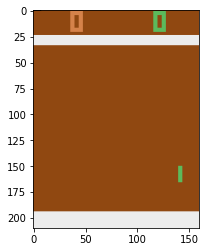

KeyboardInterrupt: 

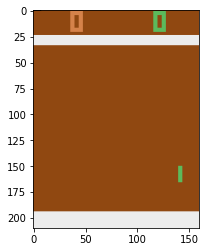

In [3]:
# Draw our frames to see what happened and print ram to find important addresses.
ram_address_position_player_y = 60
ram_address_position_ball_x = 49
ram_address_position_ball_y = 50

for i in range(len(frames)):
    plt.imshow(frames[i])
    print(frames_ram[i])
    print('Player position y: ' + str(frames_ram[i][ram_address_position_player_y]))
    print('Ball position x: ' + str(frames_ram[i][ram_address_position_ball_x]))
    print('Ball position y: ' + str(frames_ram[i][ram_address_position_ball_y]))
    display.display(pl.gcf())
    time.sleep(0.5)
    display.clear_output(wait=True)
    


In [4]:
# Create the neural network.
# TODO: What is a adam optimizer?
model = Sequential()
model.add(Dense(units=200,input_dim=3, activation='relu', kernel_initializer='glorot_uniform'))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='RandomNormal'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
import numpy as np
import gym

# gym initialization
env = gym.make("Pong-ram-v0")
observation = env.reset()
prev_input = None

# Macros
UP_ACTION = 2
DOWN_ACTION = 3

# Hyperparameters
gamma = 0.99

# initialization of variables used in the main loop
x_train, y_train, rewards = [],[],[]
reward_sum = 0
episode_nb = 0

In [6]:
log_dir = './log' + datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
resume = True
epochs_before_saving = 10

# load pre-trained model if exist
if (resume and os.path.isfile('my_model_weights.h5')):
    print("loading previous weights")
    model.load_weights('my_model_weights.h5')

In [7]:
def discount_rewards(r, gamma):
    """ take 1D float array of rewards and compute discounted reward """
    r = np.array(r)
    discounted_r = np.zeros_like(r)
    running_add = 0
    # we go from last reward to first one so we don't have to do exponentiations
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # if the game ended (in Pong), reset the reward sum
        running_add = running_add * gamma + r[t] # the point here is to use Horner's method to compute those rewards efficiently
        discounted_r[t] = running_add
    discounted_r -= np.mean(discounted_r) #normalizing the result
    discounted_r /= np.std(discounted_r) #idem
    return discounted_r

In [8]:
# main loop
while (True):
    ram = env.unwrapped._get_ram()
    position_player_y = ram[ram_address_position_player_y]
    position_ball_x = ram[ram_address_position_ball_x]
    position_ball_y = ram[ram_address_position_ball_y]

    # We will use as input an array of the difference between the current and previous positions.
    cur_input = np.array([position_player_y, position_ball_x, position_ball_y])
    #print('Current input: ' + str(cur_input))
    #print('Prev input: ' + str(prev_input))
    x = cur_input - prev_input if prev_input is not None else np.zeros(len(cur_input))
    #print('Difference: ' + str(x))
    prev_input = cur_input
    
    # forward the policy network and sample action according to the proba distribution
    proba = model.predict(np.array([x]))
    #print('Prediction: ' + str(proba))
    # Variable proba is the probability prediction of how good UP_ACTION is for this frame.
    # Then select UP_ACTION by proba percent. Easy way to still allow the other action.
    # TODO: Mathematical reason for random number?
    action = UP_ACTION if np.random.uniform() < proba else DOWN_ACTION
    y = 1 if action == UP_ACTION else 0 # 0 and 1 are our labels

    # log the input and label to train later
    x_train.append(x)
    y_train.append(y)

    # do one step in our environment
    observation, reward, done, info = env.step(action)
    #print('Observation: ' + str(observation))
    #print('Reward: ' + str(reward))
    #print('Done: ' + str(done))
    #print('Info: ' + str(info))
    rewards.append(reward)
    reward_sum += reward
    
    # end of an episode
    if done:
        print('At the end of episode', episode_nb, 'the total reward was :', reward_sum)
        
        # increment episode number
        episode_nb += 1
        
        # training
        # TODO: Is np.vstack is really necessary?
        # TODO: Clarify sample_weight=discount_rewards(rewards, gamma)
        model.fit(x=np.vstack(x_train), y=np.vstack(y_train), verbose=1, sample_weight=discount_rewards(rewards, gamma))
                                                     
        if episode_nb % epochs_before_saving == 0:    
            model.save_weights('my_model_weights' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.h5')
            
        # Reinitialization
        x_train, y_train, rewards = [],[],[]
        observation = env.reset()
        reward_sum = 0
        prev_input = None

At the end of episode 0 the total reward was : -21.0
Epoch 1/1
1091/1091 [==============================] - 0s 127us/step - loss: 0.0521 - accuracy: 0.9230
At the end of episode 1 the total reward was : -21.0
Epoch 1/1
1112/1112 [==============================] - 0s 29us/step - loss: 0.0648 - accuracy: 0.9083
At the end of episode 2 the total reward was : -21.0
Epoch 1/1
1103/1103 [==============================] - 0s 27us/step - loss: 0.0375 - accuracy: 0.9166
At the end of episode 3 the total reward was : -21.0
Epoch 1/1
1180/1180 [==============================] - 0s 23us/step - loss: 0.0208 - accuracy: 0.9331
At the end of episode 4 the total reward was : -21.0
Epoch 1/1
1164/1164 [==============================] - 0s 24us/step - loss: 0.0242 - accuracy: 0.9373
At the end of episode 5 the total reward was : -21.0
Epoch 1/1
1111/1111 [==============================] - 0s 23us/step - loss: 0.0479 - accuracy: 0.9208
At the end of episode 6 the total reward was : -21.0
Epoch 1/1
1101/1

KeyboardInterrupt: 